# Hierarchical A* path finding algorithm

Created by - Sanjana Tule

Date - 24/08/2021


* **Implement weighted risk factor**. 

Give higher weightage to risk factors compared to length. As length = 10 and risk = 2 vs length = 2 and risk = 10 should not be the same.
Weighted Risk Factor = Length + 2 * ( Building Density Risk + Distance Risk)

* **Algorithm steps/description**:

Inspired and based on ideas in the paper - https://www.researchgate.net/publication/228785110_Near_optimal_hierarchical_path-finding_HPA

Hierarchical A* algorithm are sub-optimal compared to A* but they are faster. In life threatning situations they would be most suitable than traditional A* as A* finds the complete path before returning the navigation to the user. Compared to that Hierarchical A* only returns abstract navigation path and can calculate the subpaths in parallel while the user is navigating.

Assumptions:
1.   All Street are 2 way as for earthquake people would be walking or even one-way signs can be ignored for safety purposes
2.   For implemenation simplicity only 1 entrance/exit pair between clusters are considered. But in reality we may need to store all of them as the in-flight risk might change as people navigate.

**PART 1 - Pre-processing steps to create abstract graph**:

1.   Divide grid in C clusters.
2.   For each cluster C find entry/exit nodes n.
3.   Find edge between entry and exit nodes n - intraedges e.
4.   For  each nodes define an abstract inter edge m between them and the weighted risk.
5.   Create this abstract graph based on intra edges m, inter edges e and entry/exit nodes n.
6.   Test the abstract graph using the nodes in the graph

In [1]:
# !pip install osmnx
# !apt install python3-rtree

In [2]:
# import libraries
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import requests
import osmnx as ox
import networkx as nx
import numpy as np
from geopy.geocoders import Nominatim
import math
from shapely.geometry import LineString, Point
import time

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## PART 1 - PRE-PROCESS GRAPH FUNCTIONS

In [5]:
 ##################################### PART 1 - PRE PROCESSING AND CREATING ABSTRACT GRAPH #####################################
 ###############################################################################################################################
 
 # Define all functions here.

def divide_clusters(gdf, cluster):
  cluster_info = {}
  half_cluster = cluster/2

  west  = min(graph_gdf[['bbox_west']].values)[0]
  east  = max(graph_gdf[['bbox_east']].values)[0]
  north = max(graph_gdf[['bbox_north']].values)[0]
  south = min(graph_gdf[['bbox_south']].values)[0]

  # find min and max of the graph gdf
  lon_diff =  west -  east
  lat_diff =  north - south
  
  for c in range(1,cluster+1):
    if c <= cluster/2: # Top half of the cluster
      n,s,e,w =  north, north - (lat_diff / 2) , west - ((lon_diff/half_cluster) * c) , west - ((lon_diff/half_cluster) * (c - 1))
      cluster_info[c] = [n,s,e,w]
    else:  # bottom half of the cluster
      part = c - cluster + half_cluster
      n,s,e,w =   north - (lat_diff / 2) , south, west - ((lon_diff/half_cluster) * part) , west - ((lon_diff/half_cluster) * (part - 1))
      cluster_info [c] = [n,s,e,w]
  return cluster_info


def display_clusters(cluster,cluster_info):
  # find the nodes in a cluster
  if cluster == 4:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(10,10))
  if cluster == 6:
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(10,10))

  for c in range(1,cluster+1):
    cluster_graph = ox.graph_from_bbox(cluster_info[c][0],cluster_info[c][1],cluster_info[c][2],cluster_info[c][3],network_type='drive')
    nodes,edges = ox.graph_to_gdfs(cluster_graph)
    # ### NEED TO MAKE THIS WORK FOR DYNAMIC CLUSTERS
    if c == 1: 
      ax_use = ax1 
    if c == 2:
      ax_use = ax2
    if c == 3:
      ax_use = ax3
    if c == 4:
      ax_use = ax4
    if c == 5:
      ax_use = ax5
    if c == 6:
      ax_use = ax6
    edges.plot(ax=ax_use, linewidth=1, edgecolor='#BC8F8F')
  plt.tight_layout()

def find_neighbors(cluster,cluster_info):
  c = cluster
  neighbor = []
  for c_s in range(1,c+1):
    for c_e in range(c_s+1,c+1):
      if (cluster_info[c_s][0] == cluster_info[c_e][0]  and cluster_info[c_s][1] == cluster_info[c_e][1] and cluster_info[c_s][2] == cluster_info[c_e][3]) or (cluster_info[c_s][2] == cluster_info[c_e][2]  and cluster_info[c_s][3] == cluster_info[c_e][3]):
        neighbor.append((c_s,c_e))
  return neighbor

def find_intra_edges_between_clusters(neighbor,cluster_info,nodes_nr_all,edges_nr_all):

  # create abstract edges and nodes dataframe
  abstract_intra_nodes = pd.DataFrame()
  abstract_intra_edges = pd.DataFrame()
  
  sorted_edges = edges_nr_all.sort_values(by=['combined_risk'])

  print('Processing Intra-edges between clusters')
  # for each neigbor find the edges connecting them. these edges would be entry and exit points of the cluster
  for cluster_pair in neighbor:
    #opt_length = 9999999

    c_src = cluster_pair[0]
    c_dst = cluster_pair[1]
    print("Find low risk edges between cluster {} and {}".format(c_src,c_dst))

    #find the nodes in cluster 1
    cluster_p1_graph = ox.graph_from_bbox(cluster_info[c_src][0],cluster_info[c_src][1],cluster_info[c_src][2],cluster_info[c_src][3])
    nodes_p1,_ = ox.graph_to_gdfs(cluster_p1_graph)

    #find the nodes in cluster 2
    cluster_p2_graph = ox.graph_from_bbox(cluster_info[c_dst][0],cluster_info[c_dst][1],cluster_info[c_dst][2],cluster_info[c_dst][3])
    nodes_p2,_ = ox.graph_to_gdfs(cluster_p2_graph)

    edges_found = 0
    # find the edges connecting the clusters using weighted risk factor
    for ind,cols in sorted_edges.iterrows():
      if ind[0] in nodes_p1.index and ind[1] in nodes_p2.index:
        id_src = ind[0]
        id_dst = ind[1]
        try:
          if edges_nr_all.loc[(id_src, id_dst,0)]['combined_risk'] != 0 and edges_nr_all.loc[(id_dst,id_src,0)]['combined_risk'] != 0 :
            opt_id_src = id_src
            opt_id_dst = id_dst

            # found the min risk edge
            #print('opt_id_src',opt_id_src)
            #print('opt_id_dst',opt_id_dst)

            abstract_intra_nodes = abstract_intra_nodes.append(pd.DataFrame(nodes_nr_all.loc[(opt_id_src)]).T)
            abstract_intra_nodes.at[opt_id_src,'cluster'] = int(c_src)
            abstract_intra_nodes.at[opt_id_src,'gateway'] = int(c_dst)
          
            abstract_intra_nodes = abstract_intra_nodes.append(pd.DataFrame(nodes_nr_all.loc[(opt_id_dst)]).T)
            abstract_intra_nodes.at[opt_id_dst,'cluster'] = int(c_dst)
            abstract_intra_nodes.at[opt_id_dst,'gateway'] = int(c_src)
            
            abstract_intra_edges = abstract_intra_edges.append(pd.DataFrame(edges_nr_all.loc[(opt_id_src, opt_id_dst,0)]).T)
            abstract_intra_edges = abstract_intra_edges.append(pd.DataFrame(edges_nr_all.loc[(opt_id_dst, opt_id_src,0)]).T)

            edges_found = edges_found + 1
            if edges_found == 1:
              break
        except:
          continue

  # define the index in dataframe and clean up
  abstract_intra_nodes.index.name = 'osmid' 
  abstract_intra_edges.index.names = ['u','v','key']
  abstract_intra_nodes_dedup = abstract_intra_nodes.drop_duplicates(subset=['y','x','cluster','gateway'] ,keep='first',inplace=False)

  # check the dataframe
  display(abstract_intra_edges.head())
  display(abstract_intra_nodes_dedup.head())

  # plot the new abstract graph - inter edges only
  fig, ax = plt.subplots(figsize=(20,20))
  ax.set_title('Visualise Intra-Edges (connection between clusters)')
  abstract_intra_nodes_ = geopandas.GeoDataFrame(abstract_intra_nodes_dedup,geometry='geometry')
  abstract_intra_edges_ = geopandas.GeoDataFrame(abstract_intra_edges,geometry='geometry')
  edges_nr_all.plot(ax=ax, linewidth=1, edgecolor='#ffb6c1')
  abstract_intra_nodes_.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')
  abstract_intra_edges_.plot(ax=ax, linewidth=1, edgecolor='Black')
  

  return abstract_intra_nodes_dedup,abstract_intra_edges

def find_inter_edges_in_clusters(abstract_intra_edges,abstract_intra_nodes_dedup,northridge_risk_factors_added_graph,clusters):
# STEP 5 - pre-processing step to create a high level abstract graph - create inter edges inside the clusters

  # Define dataframe columns
  cols = abstract_intra_edges.columns
  cols = cols.insert(0,'key')
  cols = cols.insert(0,'v')
  cols = cols.insert(0,'u')
  #print("cols",cols)

  abstract_inter_edges = pd.DataFrame(columns= cols)
  osmnid_dummy = 999999
  print('Processing Inter-edges in the clusters')
  #for cluster in [1.0,2.0,3.0,4.0]:
  for cluster in range(1,clusters + 1):
    print('processing cluster:',cluster)
    for ind1,gate_clu1 in abstract_intra_nodes_dedup[abstract_intra_nodes_dedup['cluster'] == cluster]['gateway'].items():
      for ind2,gate_clu2 in abstract_intra_nodes_dedup[abstract_intra_nodes_dedup['cluster'] == cluster]['gateway'].items():
          if ind1 != ind2 and gate_clu1 != gate_clu2 :
            #print("ind1",ind1)
            #print("ind2",ind2)

            # Get the nodes x and y co-ordinates
            ind1_x = abstract_intra_nodes_dedup.loc[ind1]['geometry'].centroid.x
            ind2_x = abstract_intra_nodes_dedup.loc[ind2]['geometry'].centroid.x

            ind1_y = abstract_intra_nodes_dedup.loc[ind1]['geometry'].centroid.y
            ind2_y = abstract_intra_nodes_dedup.loc[ind2]['geometry'].centroid.y

            # find the weighted risk factor and length for each inter-edges
            safest_path = nx.astar_path(G=northridge_risk_factors_added_graph, source=ind1, target=ind2, heuristic = None, weight='combined_risk')
            total_weighted_risk = sum(nx.Graph(northridge_risk_factors_added_graph)[u][v].get('combined_risk') for u, v in zip(safest_path[:-1], safest_path[1:]))
            total_length = sum(nx.Graph(northridge_risk_factors_added_graph)[u][v].get('length') for u, v in zip(safest_path[:-1], safest_path[1:]))

            # Insert the row in the dataframe
            abstract_inter_edges_append_list = [ind1,ind2,0,osmnid_dummy,'Nan','Dummy inter edge','Nan','Nan',total_length,'Nan',LineString( [ (ind1_x ,ind1_y ) , (ind2_x , ind2_y)]) ,0,0,0,0,0,total_weighted_risk,'Nan','Nan','Nan','Nan','Nan','Nan']
            print("Path Found")
            osmnid_dummy = osmnid_dummy + 1
            df_length = len(abstract_inter_edges)
            abstract_inter_edges.loc[df_length] = abstract_inter_edges_append_list
            
  # change columns to index
  abstract_inter_edges = abstract_inter_edges.set_index(['u', 'v','key'])
  display(abstract_inter_edges)

  # display the edges frame
  nodes_all,edges_all = ox.graph_to_gdfs(northridge_risk_factors_added_graph)

   # plot the new abstract graph - intra edges
  fig, ax = plt.subplots(figsize=(20,20))
  ax.set_title('Visualise Inter-Edges (connection inside clusters)')
  edges_all.plot(ax=ax, linewidth=1, edgecolor='#ffb6c1')
  abstract_inter_edges_ = geopandas.GeoDataFrame(abstract_inter_edges,geometry='geometry')
  abstract_inter_edges_.plot(ax=ax, linewidth=1, edgecolor='Black')

  return abstract_inter_edges

def combine_edges(abstract_intra_edges,abstract_inter_edges,abstract_intra_nodes,detailed_graph):

  # combine edges
  print("Combining inter and intra edges")
  abstract_edges = abstract_intra_edges.append(abstract_inter_edges)
  abstract_edges_ = geopandas.GeoDataFrame(abstract_edges,geometry='geometry')
  fig, ax = plt.subplots(figsize=(20,20))
  ax.set_title('Visualise All Edges')

  nodes_all,edges_all = ox.graph_to_gdfs(detailed_graph)
  edges_all.plot(ax=ax, linewidth=1, edgecolor='#ffb6c1')

  abstract_edges_.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')

  # make nodes
  abstract_intra_nodes_ = geopandas.GeoDataFrame(abstract_intra_nodes,geometry='geometry')
  abstract_intra_nodes_.plot(ax=ax, linewidth=1, edgecolor='Black')

  # create abstract graph
  abstract_graph = ox.graph_from_gdfs(abstract_intra_nodes_,abstract_edges_)

  return abstract_intra_nodes_,abstract_edges_,abstract_graph

def test_abstract_graph(source_node,destination_node,abstract_graph,abstract_edges_,abstract_intra_nodes_,detailed_graph):

  print('Test the abstract graph')
  # shortest path between 2 nodes in abstract graph
  shortest_path = nx.astar_path(G=abstract_graph, source=source_node, target=destination_node, heuristic = None, weight='combined_risk')
  print("Shortest Path",shortest_path)

  # plot the shortest route 
  shortest_path_df = pd.DataFrame()
  for ind,se in enumerate(shortest_path):
      if ind != len(shortest_path)-1:
        shortest_path_df = shortest_path_df.append(abstract_edges_.loc[(se,shortest_path[ind+1],0)])

  shortest_path_df_ = geopandas.GeoDataFrame(shortest_path_df,geometry='geometry')

  # plot the new abstract graph - intra edges
  fig, ax = plt.subplots(figsize=(20,20))
  ax.set_title('Visualise Path')


  nodes_all,edges_all = ox.graph_to_gdfs(detailed_graph)
  edges_all.plot(ax=ax, linewidth=1, edgecolor='#ffb6c1')
  abstract_edges_.plot(ax=ax, linewidth=1, edgecolor='Black')
  abstract_intra_nodes_.plot(ax=ax, linewidth=1, edgecolor='Black')
  shortest_path_df_.plot(ax=ax, linewidth=3, edgecolor='Red')

## PART 1 - EXECUTION

In [6]:
# 1. Load the graph,buildings and gdf from the disk and create a combined risk factor
graph_with_risk_factors = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/2_all_graph_all_risk_added.pickle')
nodes_all,edges_all = ox.graph_to_gdfs(graph_with_risk_factors)

print("Check missing values",pd.isna(edges_all['combined_risk']).sum())
display(edges_all.head())

# Load place gdf
graph_gdf = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/1_all_graph_gdf.pickle')
display(graph_gdf)

Check missing values 0


osmid   lanes  ... tunnel width
u          v          key                                  ...             
21569692   4682380491 0    [185913115, 401489878]  [5, 4]  ...    NaN   NaN
           6784129512 0                 401489883       6  ...    NaN   NaN
           6784129514 0                 401489877       3  ...    NaN   NaN
4682380491 21569692   0    [185913115, 401489878]  [5, 4]  ...    NaN   NaN
           4682381110 0                 474236841     NaN  ...    NaN   NaN

[5 rows x 20 columns]

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((-118.56428 34.26059, -118.56426 34.2...",34.278403,34.220380,-118.491475,-118.564275,306436970,relation,7753455,34.234561,-118.536932,"Northridge, Los Angeles, California, United St...",boundary,administrative,0.638973
1,"POLYGON ((-118.64769 34.23529, -118.58368 34.2...",34.282445,34.231870,-118.562174,-118.647688,259222194,relation,9620404,34.259571,-118.602325,"Chatsworth, Los Angeles, California, United St...",boundary,administrative,0.640064
2,"POLYGON ((-118.50248 34.25023, -118.49150 34.2...",34.257558,34.220155,-118.451787,-118.502485,258910793,relation,6697372,34.242958,-118.485408,"North Hills, Los Angeles, California, United S...",boundary,administrative,0.600812


In [9]:
# 2. Divide into clusters and find the neighbouring clusters
cluster = 12
cluster_info = divide_clusters(graph_gdf,cluster)
display(cluster_info)
#display_clusters(cluster,cluster_info)
neighbor = find_neighbors(cluster,cluster_info)
display(neighbor)

{1: [34.2824454, 34.2513001, -118.61503751666666, -118.6476876],
 2: [34.2824454, 34.2513001, -118.58238743333334, -118.61503751666666],
 3: [34.2824454, 34.2513001, -118.54973735, -118.58238743333334],
 4: [34.2824454, 34.2513001, -118.51708726666666, -118.54973735],
 5: [34.2824454, 34.2513001, -118.48443718333334, -118.51708726666666],
 6: [34.2824454, 34.2513001, -118.4517871, -118.48443718333334],
 7: [34.2513001, 34.2201548, -118.61503751666666, -118.6476876],
 8: [34.2513001, 34.2201548, -118.58238743333334, -118.61503751666666],
 9: [34.2513001, 34.2201548, -118.54973735, -118.58238743333334],
 10: [34.2513001, 34.2201548, -118.51708726666666, -118.54973735],
 11: [34.2513001, 34.2201548, -118.48443718333334, -118.51708726666666],
 12: [34.2513001, 34.2201548, -118.4517871, -118.48443718333334]}

[(1, 2),
 (1, 7),
 (2, 3),
 (2, 8),
 (3, 4),
 (3, 9),
 (4, 5),
 (4, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12)]

Processing Intra-edges between clusters
Find low risk edges between cluster 1 and 2
Find low risk edges between cluster 1 and 7
Find low risk edges between cluster 2 and 3
Find low risk edges between cluster 2 and 8
Find low risk edges between cluster 3 and 4
Find low risk edges between cluster 3 and 9
Find low risk edges between cluster 4 and 5
Find low risk edges between cluster 4 and 10
Find low risk edges between cluster 5 and 6
Find low risk edges between cluster 5 and 11
Find low risk edges between cluster 6 and 12
Find low risk edges between cluster 7 and 8
Find low risk edges between cluster 8 and 9
Find low risk edges between cluster 9 and 10
Find low risk edges between cluster 10 and 11
Find low risk edges between cluster 11 and 12


,,,osmid,lanes,name,highway,oneway,length,ref,geometry,distance_risk_score,max_speed_risk_score,density_risk_score,width_risk_score,liq_risk_score,combined_risk,access,bridge,maxspeed,service,tunnel,width
u,v,key,,,,,,,,,,,,,,,,,,,,
123378844,122502372,0,13408198,2,Santa Susana Pass Road,primary,False,85.426,NaN,"LINESTRING (-118.6151862 34.2725009, -118.6142...",0.9,0.4,0.101382,0.2,1,1.55138,NaN,NaN,NaN,NaN,NaN,NaN
122502372,123378844,0,13408198,2,Santa Susana Pass Road,primary,False,85.426,NaN,"LINESTRING (-118.6142635 34.2725948, -118.6151...",0.9,0.4,0.101382,0.2,1,1.55138,NaN,NaN,NaN,NaN,NaN,NaN
8747789131,8747739107,0,944893222,NaN,Miranda Loop Trail,path,False,302.112,NaN,"LINESTRING (-118.6264985 34.2513155, -118.6265...",0.922222,0.8,0.0322581,1,0,1.85448,NaN,NaN,NaN,NaN,NaN,NaN
8747739107,8747789131,0,944893222,NaN,Miranda Loop Trail,path,False,302.112,NaN,"LINESTRING (-118.6268802 34.2494636, -118.6269...",0.922222,0.8,0.0322581,1,0,1.85448,NaN,NaN,NaN,NaN,NaN,NaN
6784328049,364429816,0,"[401089545, 401089567]","[6, 4]",Devonshire Street,primary,False,219.34,NaN,"LINESTRING (-118.5841086 34.2572526, -118.5834...",0.922222,0.4,0.506912,0.2,0,1.72913,NaN,NaN,40 mph,NaN,NaN,NaN


,y,x,highway,street_count,evacuation_flag,evacuation_name,ref,evacuation_type,geometry,cluster,gateway
osmid,,,,,,,,,,,
123378844,34.2725,-118.615,NaN,3,N,NA,NaN,NaN,POINT (-118.6151862 34.2725009),1.0,2.0
122502372,34.2726,-118.614,NaN,3,N,NA,NaN,NaN,POINT (-118.6142635 34.2725948),2.0,1.0
8747789131,34.2513,-118.626,NaN,3,N,NA,NaN,NaN,POINT (-118.6264985 34.2513155),1.0,7.0
8747739107,34.2495,-118.627,NaN,3,N,NA,NaN,NaN,POINT (-118.6268802 34.2494636),7.0,1.0
6784328049,34.2573,-118.584,NaN,4,N,NA,NaN,NaN,POINT (-118.5841086 34.2572526),2.0,3.0


Processing Inter-edges in the clusters
processing cluster: 1
Path Found
Path Found
processing cluster: 2
Path Found
Path Found
Path Found
Path Found
Path Found
Path Found
processing cluster: 3
Path Found
Path Found
Path Found
Path Found
Path Found
Path Found
processing cluster: 4
Path Found
Path Found
Path Found
Path Found
Path Found
Path Found
processing cluster: 5
Path Found
Path Found
Path Found
Path Found
Path Found
Path Found
processing cluster: 6
Path Found
Path Found
processing cluster: 7
Path Found
Path Found
processing cluster: 8
Path Found
Path Found
Path Found
Path Found
Path Found
Path Found
processing cluster: 9
Path Found
Path Found
Path Found
Path Found
Path Found
Path Found
processing cluster: 10
Path Found
Path Found
Path Found
Path Found
Path Found
Path Found
processing cluster: 11
Path Found
Path Found
Path Found
Path Found
Path Found
Path Found
processing cluster: 12
Path Found
Path Found


osmid lanes              name  ... service tunnel  width
u          v          key                                   ...                      
123378844  8747789131 0     999999   Nan  Dummy inter edge  ...     Nan    Nan    Nan
8747789131 123378844  0    1000000   Nan  Dummy inter edge  ...     Nan    Nan    Nan
122502372  6784328049 0    1000001   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           6784328065 0    1000002   Nan  Dummy inter edge  ...     Nan    Nan    Nan
6784328049 122502372  0    1000003   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           6784328065 0    1000004   Nan  Dummy inter edge  ...     Nan    Nan    Nan
6784328065 122502372  0    1000005   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           6784328049 0    1000006   Nan  Dummy inter edge  ...     Nan    Nan    Nan
364429816  7241989439 0    1000007   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           7809822849 0    1000008   Nan  Dummy inter edge  ...     Nan    Nan    Nan
7241989439 364429816  0    1000009   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           7809822849 0    1000010   Nan  Dummy inter edge  ...     Nan    Nan    Nan
7809822849 364429816  0    1000011   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           7241989439 0    1000012   Nan  Dummy inter edge  ...     Nan    Nan    Nan
7159751453 8239124550 0    1000013   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           6654203173 0    1000014   Nan  Dummy inter edge  ...     Nan    Nan    Nan
8239124550 7159751453 0    1000015   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           6654203173 0    1000016   Nan  Dummy inter edge  ...     Nan    Nan    Nan
6654203173 7159751453 0    1000017   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           8239124550 0    1000018   Nan  Dummy inter edge  ...     Nan    Nan    Nan
7920113441 7241306858 0    1000019   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           122849351  0    1000020   Nan  Dummy inter edge  ...     Nan    Nan    Nan
7241306858 7920113441 0    1000021   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           122849351  0    1000022   Nan  Dummy inter edge  ...     Nan    Nan    Nan
122849351  7920113441 0    1000023   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           7241306858 0    1000024   Nan  Dummy inter edge  ...     Nan    Nan    Nan
7241306857 123145547  0    1000025   Nan  Dummy inter edge  ...     Nan    Nan    Nan
123145547  7241306857 0    1000026   Nan  Dummy inter edge  ...     Nan    Nan    Nan
8747739107 8218741684 0    1000027   Nan  Dummy inter edge  ...     Nan    Nan    Nan
8218741684 8747739107 0    1000028   Nan  Dummy inter edge  ...     Nan    Nan    Nan
7227130250 122684413  0    1000029   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           5544335198 0    1000030   Nan  Dummy inter edge  ...     Nan    Nan    Nan
122684413  7227130250 0    1000031   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           5544335198 0    1000032   Nan  Dummy inter edge  ...     Nan    Nan    Nan
5544335198 7227130250 0    1000033   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           122684413  0    1000034   Nan  Dummy inter edge  ...     Nan    Nan    Nan
7809822845 7222446499 0    1000035   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           6556265356 0    1000036   Nan  Dummy inter edge  ...     Nan    Nan    Nan
7222446499 7809822845 0    1000037   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           6556265356 0    1000038   Nan  Dummy inter edge  ...     Nan    Nan    Nan
6556265356 7809822845 0    1000039   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           7222446499 0    1000040   Nan  Dummy inter edge  ...     Nan    Nan    Nan
6028589506 6708536248 0    1000041   Nan  Dummy inter edge  ...     Nan    Nan    Nan
           7257529019 0    1000042   Nan  Dummy inter edge  ...     Nan    Nan    Nan
6708536248 6028589506 0    1000043   Nan  Dummy inter edge  ...     Nan  

Combining inter and intra edges


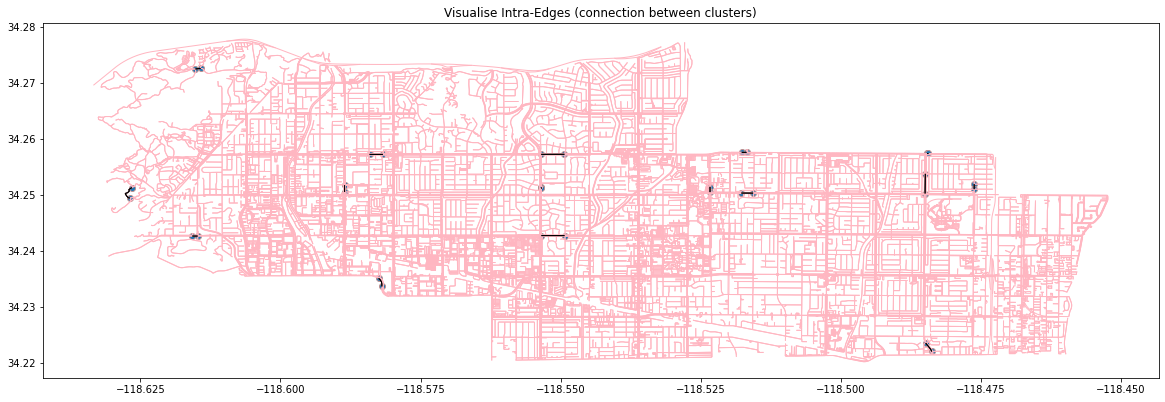

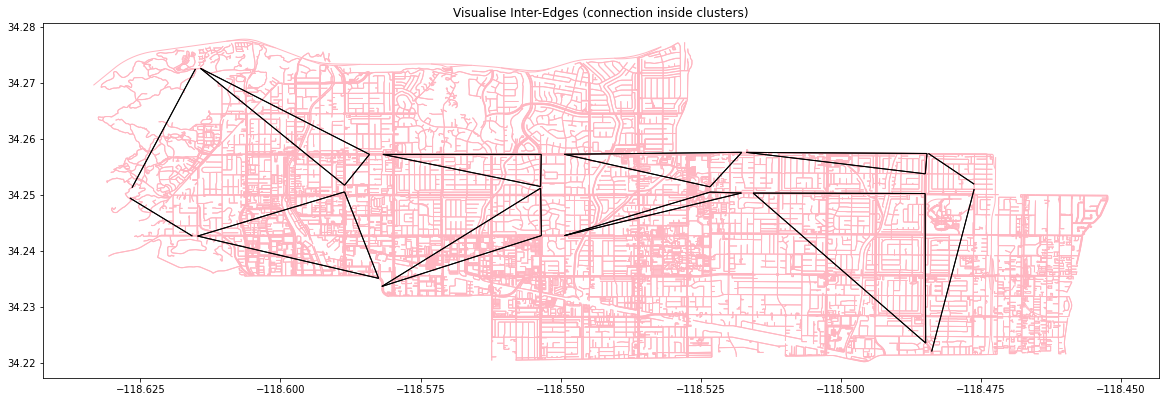

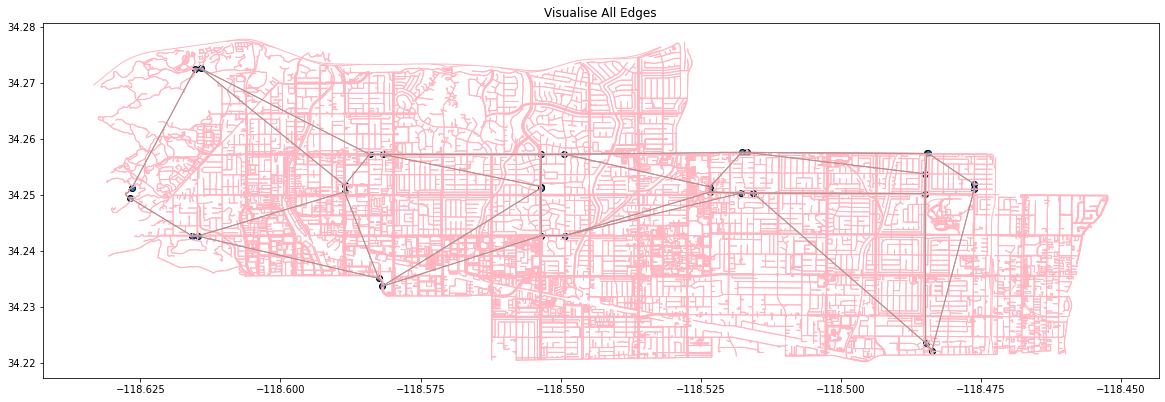

In [10]:
# 3. Find the abstract intra cluster nodes and edges
abstract_intra_nodes,abstract_intra_edges = find_intra_edges_between_clusters(neighbor,cluster_info,nodes_all,edges_all)

# 4. Find the inter cluster edges
abstract_inter_edges = find_inter_edges_in_clusters(abstract_intra_edges,abstract_intra_nodes,graph_with_risk_factors,cluster)

# 5. Combine edges
abstract_nodes_all,abstract_edges_all,abstract_graph = combine_edges(abstract_intra_edges,abstract_inter_edges,abstract_intra_nodes,graph_with_risk_factors)

Test the abstract graph
Shortest Path [6784328049, 364429816, 7241989439, 7159751453, 6654203173, 6028589506, 7257529019, 6432919600, 6780182666]


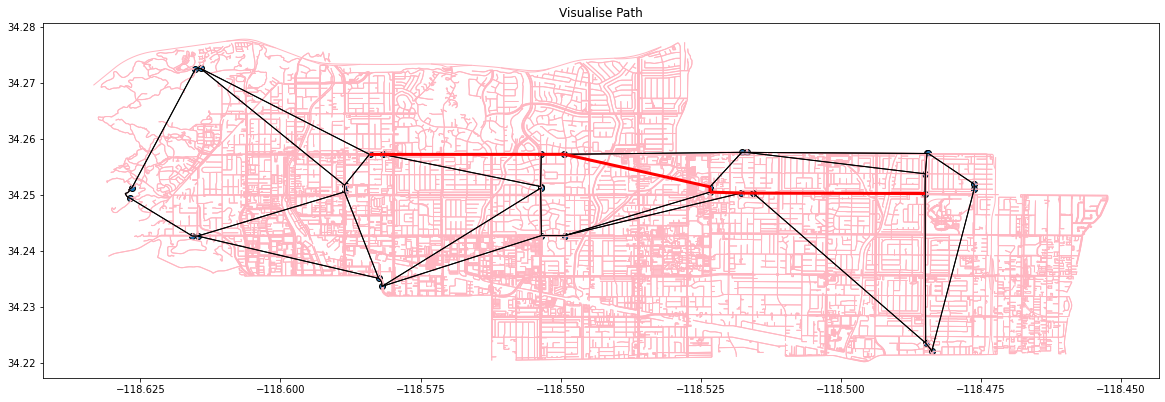

In [11]:
# 5. Test the abstract graph
source_node = 6784328049
destination_node = 6780182666
test_abstract_graph(source_node,destination_node,abstract_graph,abstract_edges_all,abstract_nodes_all,graph_with_risk_factors)

In [12]:
# 6. Save the abstract graph
nx.write_gpickle(abstract_graph,'/content/drive/My Drive/omdena/earthquake/3_abstract_graph.pickle')